In [2]:
# Import the packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import copy
from numpy.linalg import inv
from pandas_datareader.data import DataReader
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from scipy import signal
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from scipy.optimize import root
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.compat import lzip
from statsmodels.tsa.stattools import adfuller

You can use, for a VAR, the package 'statsmodel' to calculate IRFS. The next example gives you an hint on how to do it with simulated data.

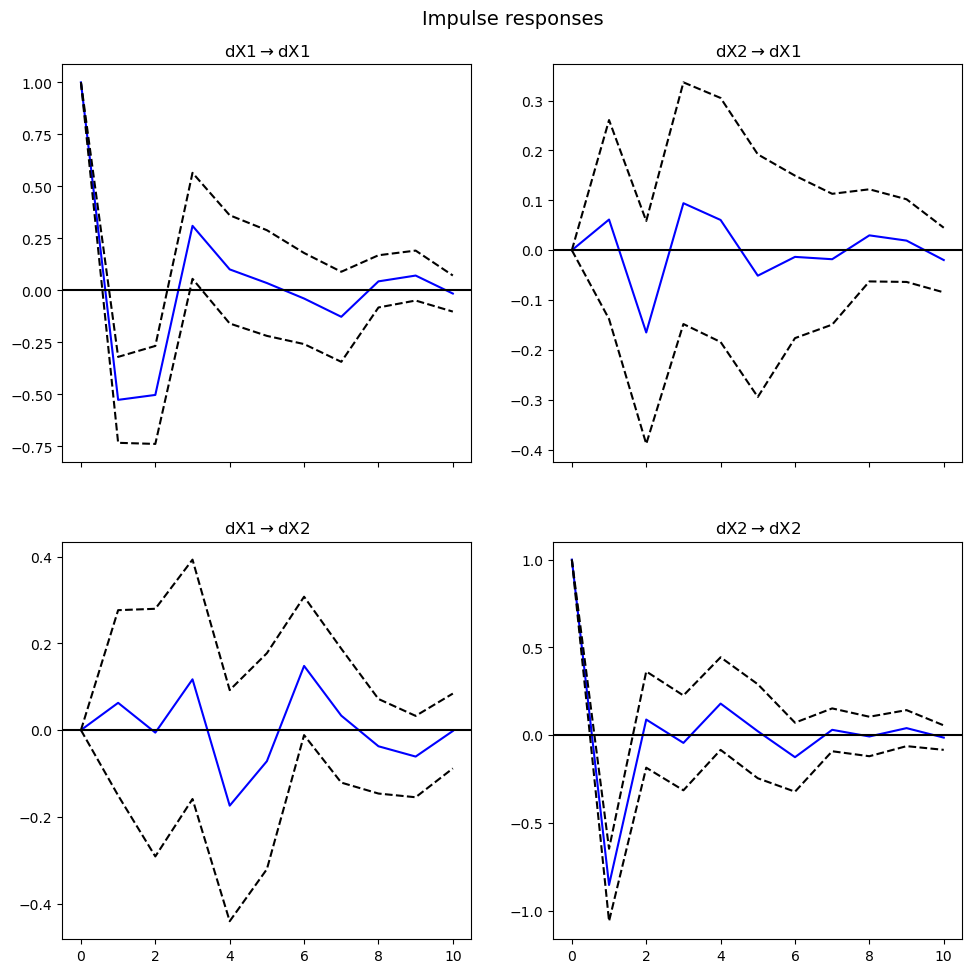

In [17]:
# Generate some sample data
np.random.seed(0)
n_obs = 100
data = np.random.normal(size=(n_obs, 2))
data += np.arange(n_obs)[:, np.newaxis]

# Create a DataFrame
df = pd.DataFrame(data, columns=['X1', 'X2'])

df['dX1'] = df['X1'] -  df["X1"].shift(1)
df['dX2'] = df['X2'] -  df["X2"].shift(1)
df = df[1:] #eliminate NaN

X_test = df.loc[:,["dX1","dX2"]].copy() # we only want dX1 and dX2
# Fit VAR model
model = VAR(X_test)
order = 4  # Order of VAR model
results = model.fit(order)

# Plot impulse response functions
irf = results.irf(periods=10)
# Plot IRFs
irf.plot(orth=False)  # Orthogonalization can be set to True or False based on preference
plt.show()

In order to use this package, students should exercise caution regarding the accurate specification of their models. It is essential to carefully define the variables included in the analysis, choose appropriate lag lengths, and consider potential endogeneity issues. Moreover, if students intend to impose restrictions or estimate a structural vector autoregression (SVAR), they must ensure a thorough understanding of the underlying economic theory and the implications of these restrictions on the model's interpretation.

## Practical Example: Blanchard and Quah (1989)

Let's continue from the previous example. As it was stated before, this model is a replication of the seminal paper titled "The Dynamic Effects of Aggregate Demand and Supply Disturbances," published in the American Economic Review in 1989. In this paper, the authors propose a methodology to decompose fluctuations in output and prices into components attributable to aggregate demand (AD) and aggregate supply (AS) disturbances. They argue that understanding the relative contributions of demand and supply shocks to economic fluctuations is essential for policymakers to formulate effective stabilization policies.

The authors consider $X(t)=(\Delta Y(t), U(t))^{\prime}$, where $\Delta Y$ is the first difference of the $\log$ of GNP and $U$ the log of the unemployment rate. These are assumed to be stationary, and as such the Wold decomposition guarantees that $X(t)$ can be expressed by an infinite moving-average of the vector of disturbances $e=\left(e_{d}, e_{s}\right)^{\prime}$ :

$$
X(t)=\sum_{j=0}^{\infty} A(j) e(t-j)
$$
                
However, directly from the data, we only obtain the moving average representation of the reduced-form VAR - by first estimating the vector autoregressive representation of $X$ and subsequently inverting it - which is given by:
      
$$
X(t)=\sum_{j=0}^{\infty} C(j) v(t-j)
$$
                
where $C(0)=I$ and $\operatorname{var}(v)=\Omega$. The two equations imply that $A(j) e(t-j)=C(j) v(t-j)$, and also that $A(0) e(t)=v(t)$, for every $t$. Put together, those entail $A(j) e(t-j)=$ $C(j) A(0) e(t-j)=>A(j)=C(j) A(0)$. Hence, knowing $A(0)$ will allow us to recover both $A(j)$ and $e$. For such, a restriction on the variance-covariance matrix of the structural disturbances needs to be imposed. Since
                
$$
\Omega=A(0) E\left(e . e^{\prime}\right) A(0)^{\prime}
$$
                
the assumption that the demand and supply disturbances are uncorrelated and the normalization of both shocks render

$$
\Omega=A(0) A(0)^{\prime}
$$

, which given the symmetry of $\Omega$ means we have only three conditions to identify the four elements of $A(0)$.

The needed fourth condition results from what defines the supply and demand disturbances. Contrary to the latter, the former has no long-run effect on output. Note that once $X$ is stationary, neither disturbance has a long-run effect on unemployment or the rate of change in output. However, the level of output that results from such $\Delta Y$ process is such that the long-run effect on $Y$ of the demand and supply disturbances is, respectively, $\sum_{j=0}^{\infty} a_{11}(j)$ and $\sum_{j=0}^{\infty} a_{12}(j)$.Therefore, imposing that in the long-run output is solely driven by supply shocks, by setting $\sum_{j=0}^{\infty} a_{11}(j)=0$, will produce the required fourth condition to identify $e$. Put it differently, as the implied level of output is

$Y(t)=v^{\Delta Y}(t)+\left(I+C_{11}(1)\right) v^{\Delta Y}(t-1)+\ldots+\left(I+C_{11}(1)+\ldots+C_{11}(k)\right) v^{\Delta Y}(t-k)+\ldots$

the long-run effects are given by,

$$
\left(\sum_{j=0}^{\infty} C_{11}(j)\right) \cdot A(0)
$$

and the fourth condition results from setting the upper left-hand entry of this last matrix equal to zero.

In [18]:
# Construction of Matrix X
'''
Downloading and preparing data using DataReader
'''
           
#Sample selection
start = '1948Q1'                                              
end = '1987Q3'

#Data from FRED
gdp = DataReader('GNPC96', 'fred', start=start,  end=end) # quarterly frequency
urate = DataReader('UNRATE', 'fred', start=start, end=end)  # monthly frequency

'''
Transforming the data part 1
'''

#Frequency change for urate
urateq = urate.resample('Q').mean() # Convenience method for frequency conversion and resampling of time series. 
                                    # Object must have a datetime-like index 
#urateq = urate.groupby(pd.PeriodIndex(urate.index, freq='Q'), axis=0).mean()

#From YYYYQ format to date format (find it important for matplotlib)
gdp.index = pd.date_range(start,'1987Q4',freq="Q")
urateq.index = pd.date_range(start,'1987Q4',freq="Q")

#create Data Frame
df = pd.concat((urateq, gdp), axis=1)
df.columns = ["urate","gdp"]
df["lngdp"] = np.log(df["gdp"])
df["dy"] = (df["lngdp"] - df["lngdp"].shift(1))*400 #annualized quarterly GDP growth
df = df[1:] # drop first observation

'''
Transforming the data part 2
'''

# Detrending as in the paper: Important to make the data covariance stationary
# Productivity Slowdown less apparent than in origal data, upward trend in urate present

df.loc[:"1973Q2","dys"] = signal.detrend(df.loc[:"1973Q2","dy"],type="constant")
df.loc["1973Q3":,"dys"] = signal.detrend(df.loc["1973Q3":,"dy"],type="constant")
df["urates"] = signal.detrend(df["urate"])

#Setting up the data for VAR
X = df.loc[:,["dys","urates"]].copy()

'''
VAR with a OLS
'''
XLAG = pd.DataFrame()
num_lags = 8 
for i in range(1,num_lags+1):
    XLAG = pd.concat([XLAG,X.shift(i).add_suffix("-"+str(i))],axis=1)
#change names to frames that we modify    
X2 = X.iloc[num_lags:,:]
XLAG2 = XLAG.iloc[num_lags:,:]
num_vars = X2.shape[1]
num_obs = XLAG2.shape[0]

#changing to arrays 
X3 = np.array(X2)
XLAG3 = np.array(XLAG2)

#VAR - standard OLS
Bhat = inv(XLAG3.T@XLAG3)@XLAG3.T@X3

#### Canonical form
$$X_{t}=B(1)X_{t-1}+B(2)X_{t-2}+...+B(p)X_{t-p}+v_{t}$$


$$\left[\begin{array}{c}
X_{t}\\
X_{t-1}\\
...\\
X_{t-p}
\end{array}\right]=\left[\begin{array}{cccc}
B(1) & B(2) & ... & B(p)\\
I_{n} & 0 & ... & 0\\
0 & I_{n} & ... & 0\\
0 & 0 & ... & 0
\end{array}\right]\left[\begin{array}{c}
X_{t-1}\\
X_{t-2}\\
...\\
X_{t-p-1}
\end{array}\right]+...+\left[\begin{array}{c}
I_{n}\\
0\\
0\\
0
\end{array}\right]v_{t}$$

$$X_{t}^{c}=B^{c}X_{t-1}^{c}+G^{c}v_{t}$$

$$X_{t}^{c}=(I-B^{c}L)^{-1}G^{c}v_{t}$$

You have to work with the first *n* rows

In [19]:
# Putting problem in canonical form (VAR(8) into VAR(1))
# c_x(t) = c_Bhat*c_x(t-1) + c_G*eta(t)
# c_Bhat = [ Bhat' ; eye((n_lags-1)*n_vars) zeros((n_lags-1)*n_vars,n_vars) ] ;

c_Bhat = np.vstack((Bhat.T,np.hstack((np.identity((num_lags-1)*num_vars),
                                      np.zeros([(num_lags-1)*num_vars,num_vars]))))) 

#Setting up for LR restriction
c_Mhat = inv(np.identity(c_Bhat.shape[0])-c_Bhat)
Mhat = c_Mhat[:2,:2]

#### Identification
Now let us apply our identification restrictions to the covariance matrix of the estimated innovations $v=A(0)\epsilon$
1. $\epsilon\epsilon'=I$ therefore $\Omega=A(0)A(0)'$, gives us three restrictions
2. $LR_{11}=0$ where $LR=(I+C(1)+C(2)+...)A(0)=(I-C)^{-1}A(0)$, gives us one restriction.
In our code denote $(I-C)^{-1}$ as Mhat

In [20]:
'''
Construct Omega
'''
#Estimated errors
EPS = (X3 - XLAG3@Bhat)
#estimated covariance matrix
Omegahat = EPS.T@EPS/(num_obs - num_lags*num_vars)

'''
objective function to impose restrictions on the variance covariance matrix
of the estimated reduced form, starts with x0, outputs H,
which it uses again as x0 until convergence
'''
def objective(x0,Mhat,Omegahat,num_vars):   
    
    A0   = np.reshape(x0,[num_vars,num_vars]) #grab starting values, and create a possible matrix  A(0)
    LR  = Mhat@A0                             #LR effect given by multiplication of Mhat and A0
    H   = A0@A0.T - Omegahat                  #A(0)*A(0).T should be equal to Omegahat, 
                                              #as variance of shocks is identity
    H[0,1] = LR[0,1]                          #We add LR restriction: since I guarantee that H=0, then LR[0,1] must be also = 0
    H = H.flatten()
    return H #each parameter in H must be equal to 0, including LR restriction

'''
solve the system of equation to find the structural parameters
'''
x0 = ((Omegahat**2)**.25).flatten() #Starting values, flatten is needed for root function below
#returns the values of G, A(0), which guarantee LR restriction = 0,
#as well as the information from variance-covariance matrix
sol = root(objective,x0,args=(Mhat,Omegahat,num_vars)) # Solves F(X) = 0, where both X and 0 can be vectors
A0   = sol.x.reshape([num_vars,num_vars])
#the first shock (supply) should have a positive impact on output (only redefines direction, and changes nothing)
if A0[0,0] < 0: A0[:,0] = -A0[:,0]
#the second shock (demand) should have a positive impact on output (only redefines direction, and changes nothing)
if A0[0,1] < 0: A0[:,1] = -A0[:,1]
#Estimating structural shocks, ETA
F = inv(A0)
ETA = EPS@F.T

In macroeconometrics, IRFs are essential tools for understanding the dynamic effects of shocks on economic variables within a system. IRFs illustrate how an exogenous shock to one variable propagates through the system and affects other endogenous variables over time. They are particularly useful for examining the response of variables to policy changes, economic shocks, or other exogenous events.

Once the VAR model is estimated, IRFs can be computed by simulating the response of the endogenous variables to a series of predetermined impulse shocks. These shocks are often represented as innovations to one or more variables in the system, and the resulting responses of the variables are then traced out over several periods.

We can now compute the IRF
$$\hat{X}_{t+s}=\sum_{i=0}^{s-1}C_{i}A(0)e_{t+s-i}$$
define $$\Psi_{i}=\left[\left(C\right)^{i}A(0)\right]$$
you want to study $$\frac{\partial\hat{X}_{t+s}}{\partial e_{t}}=\Psi_{s}$$

In [21]:
# number of periods for IRFS and VARDEC
num_impulses = 40

'''IRFs are stored in a 3-dimensional array. Dimension 1 is time. Dimension
    2 is variable, and 3 is shock. So IRF(:,2,1) gives the impulse response
    of the second variable to the first shock. IRF_sum gives the integrated
    responses (i.e, in levels). IRF_sum(:,1,1) gives the cumulative impulse
    response of variable 1 to shock 1.'''
    
IRF  = np.zeros([num_impulses,num_vars,num_vars])
Temp = np.identity(c_Bhat.shape[0])

psi  = []
for t in range(num_impulses):
    psi_t = Temp[:num_vars,:num_vars] 
    IRF[t,:,:] = psi_t@A0 # store the IRF
    Temp = c_Bhat@Temp   # computes the exponent of the matrix
    #psi.append(psi_t)            # stores the matrices Psi (notations as in Hamilton)

irf  = pd.DataFrame({i:IRF[i].flatten() for i in range(num_impulses)}).T #save IRFs into dataframe
irf.columns = ["s_y","d_y","s_u","d_u"]
irf_cum = irf.cumsum() #output is expressed cumulatively

irf_final = pd.concat([irf_cum["s_y"], #supply shock on output
                       irf_cum["d_y"], #demand shock on output
                       irf["s_u"], #supply shock on unemployment
                       irf["d_u"]],axis=1) #demand shock on unemployment

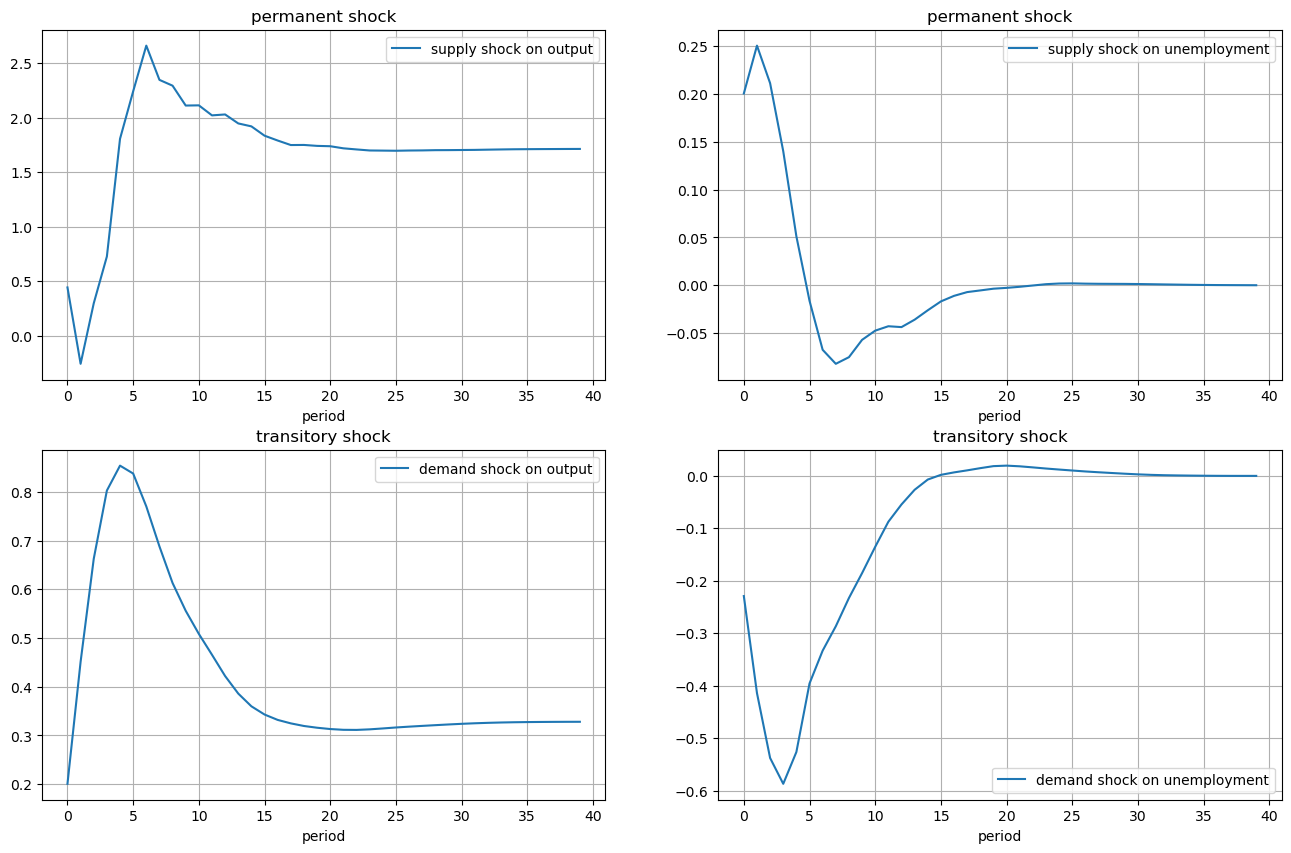

In [22]:
# Plot the IRFs

plt.figure(figsize=(16,10))
plt.subplot(221)
plt.plot(irf_cum["s_y"],label='supply shock on output')
plt.legend()
plt.xlabel('period')
plt.title('permanent shock')
plt.grid()
plt.subplot(222)
plt.plot(irf["s_u"],label='supply shock on unemployment')
plt.legend()
plt.xlabel('period')
plt.title('permanent shock')
plt.grid()
plt.subplot(223)
plt.plot(irf_cum["s_u"],label='demand shock on output')
plt.legend()
plt.xlabel('period')
plt.title('transitory shock')
plt.grid()
plt.subplot(224)
plt.plot(irf["d_u"],label='demand shock on unemployment')
plt.legend()
plt.xlabel('period')
plt.title('transitory shock')
plt.grid()
plt.show()